In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import math
import numpy as np

import asyncio
import concurrent.futures

import predict

14
14


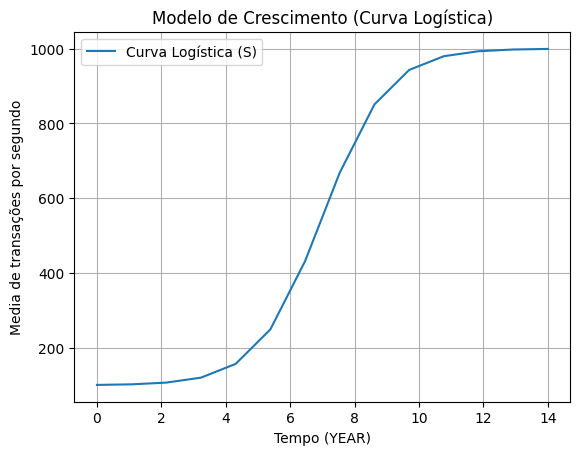

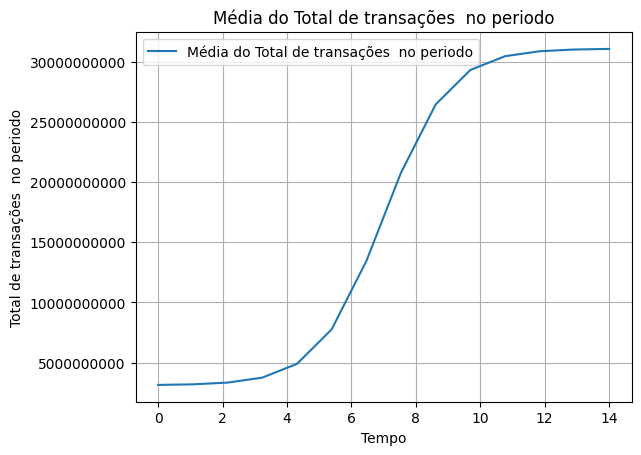

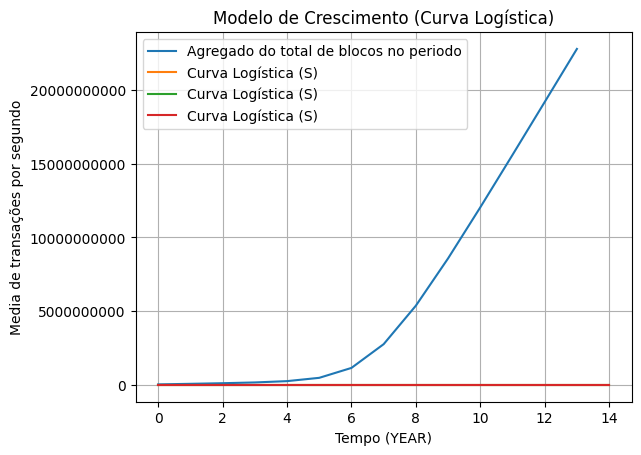

In [11]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

# Dados de exemplo de tempo (t)
global PREDICT_TYPE
PREDICT_TYPE = 'YEAR' #'DAY':'WEEK':'MONTH':'YEAR'
A = 14 #D
print(A)
t = np.linspace(0, A , A)
print(len(t))

# Parâmetros da curva logística
P0 = 100  # Transações inicial
K = 1000  # Valor máximo transações estimado
r =  1 # Taxa de crescimento
t0 = A / 2     # Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística
global rate_transactions
AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)

# Plotagem da curva logística
plt.plot(t, AVG_RATE_TRANSACTIONS, label='Curva Logística (S)')
plt.xlabel(f'Tempo ({PREDICT_TYPE})')
plt.ylabel('Media de transações por segundo')
plt.title('Modelo de Crescimento (Curva Logística)')
plt.legend()
plt.grid(True)
plt.show()

In [3]:

def expand_transations_by_period(predict_type, rate_transations):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transations: rate_transations * SECONDS_PER_DAY,
    'WEEK': lambda rate_transations: rate_transations * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transations: rate_transations * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transations: rate_transations * SECONDS_PER_DAY * 30 * 12
    }[predict_type](rate_transations)

total_transactions_by_period = expand_transations_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

In [4]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(t, total_transactions_by_period, label='Média do Total de transações  no periodo')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de transações  no periodo')
plt.title('Média do Total de transações  no periodo')
plt.legend()
plt.show()

In [5]:

blockchain_predict = predict.blockchain_predict()


def estimate_blocks(blockchain_predict, avg_tps, total_transations_period):
    total_blocks = None
    batch_type  = ""
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = blockchain_predict.max_message_count  / avg_tps

    #Quantas transações eu preciso para fechar um bloco para max_bytes
    aggregate_total_transations_if_batch_max_bytes = blockchain_predict.absolute_max_bytes / blockchain_predict.transation_size
    time_to_batch_bytes  = aggregate_total_transations_if_batch_max_bytes / avg_tps
    total_blocks = None
    if time_to_batch_messages >= blockchain_predict.batch_timeout and \
        time_to_batch_bytes >=  blockchain_predict.batch_timeout:

        #calcular por batchtimeout
        aggregate_total_transations_if_batch_timeout = blockchain_predict.batch_timeout * avg_tps
        total_blocks = total_transactions_by_period / aggregate_total_transations_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes:
        total_blocks = total_transations_period / time_to_batch_messages
        batch_type = "batch_message"
        #batch messages
    
    elif time_to_batch_bytes    < time_to_batch_messages:
        total_blocks = total_transations_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        #batch bytes
    else:
        raise Exception
        
    
    return total_blocks, batch_type

StorageDemand = []


for i_period in range(0,len(AVG_RATE_TRANSACTIONS)):
    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    total_transations_by_period = total_transactions_by_period[i_period]
    print(avg_t)
    print(total_transations_by_period)

    i_storage_demand = predict.StorageDemand()
    i_storage_demand.period                       = i_period    
    i_storage_demand.total_transactions           = total_transations_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type                 = estimate_blocks(blockchain_predict, avg_t, total_transations_by_period)
    i_storage_demand.calculated_total_size_blocks = (i_storage_demand.total_blocks * blockchain_predict.calculate_block_headers_size()) + (i_storage_demand.total_transactions * blockchain_predict.transation_size)
    
    StorageDemand.append(i_storage_demand)
    


100.81994607496058
3135903602.715574
102.40282340863365
3185137419.302141
107.01754253167665
3328673642.9052706
120.2946291337128
3741644144.5750027
157.08591131061885
4886000185.405489
249.25813486793928
7752925026.932383
431.6909861321843
13427316432.65546
668.3090138678156
20787083567.344536
850.7418651320605
26461474973.067616
942.9140886893812
29328399814.594513
979.7053708662872
30472755855.425
992.9824574683232
30885726357.094727
997.5971765913663
31029262580.697853
999.1800539250395
31078496397.284424


In [6]:
for s in StorageDemand:
    atributos = vars(s)
    # Iterando sobre o dicionário e imprimindo os atributos
    for chave, valor in atributos.items():
        print(f"{chave}: {valor}")

total_blocks: 36664251.77196726
total_transactions: 3135903602.715574
calculated_total_size_blocks: 3820298317242.3555
batch_type: batch_bytes
period: 0
total_blocks: 37824549.73717979
total_transactions: 3185137419.302141
calculated_total_size_blocks: 3880389415420.9424
batch_type: batch_bytes
period: 1
total_blocks: 41310443.05371113
total_transactions: 3328673642.9052706
calculated_total_size_blocks: 4055598754839.1216
batch_type: batch_bytes
period: 2
total_blocks: 52196619.87132313
total_transactions: 3741644144.5750027
calculated_total_size_blocks: 4559861030818.497
batch_type: batch_bytes
period: 3
total_blocks: 89007043.7254468
total_transactions: 4886000185.405489
calculated_total_size_blocks: 5958465577848.36
batch_type: batch_bytes
period: 4
total_blocks: 224103472.94737875
total_transactions: 7752925026.932383
calculated_total_size_blocks: 9470584699555.674
batch_type: batch_bytes
period: 5
total_blocks: 672195910.440164
total_transactions: 13427316432.65546
calculated_tota

In [7]:
i_period           = np.array([s.period for s in StorageDemand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in StorageDemand]) )

# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()
ax.plot(i_period, cumulative_blocks, label='Agregado do total de blocos no periodo')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('Quantidade de blocos')
plt.title('Agregado do total de blocos no periodo')
plt.legend()
plt.show()
